In [1]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time, sys
import pickle
from scipy.io import savemat

In [2]:
np.set_printoptions(threshold=sys.maxsize)

In [3]:
# Choose either Re=1000 or Re=100
Re=10000

# load FOM solutions
if Re==10000:
    nx=60
    ny=60
    nt=1500
    
    FOM_solution=pickle.load(open('./data/FOM_high_Re.p','rb'))
elif Re==100:
    nx=60
    ny=60
    nt=1500
    
    FOM_solution=pickle.load(open('./data/FOM_low_Re.p','rb'))
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
u_full=FOM_solution['u']
v_full=FOM_solution['v']

u0=np.copy(u_full[0])
v0=np.copy(v_full[0])

# set parameters
nxy=(nx-2)*(ny-2)
dx=1/(nx-1)
dy=1/(ny-1)
dt=2/nt

I=sp.eye(nxy,format='csr')

# full indicies, free indicies, fixed indicies
[xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())
x0_multi_index=(multi_index_j[1:-1,0].flatten(),multi_index_i[1:-1,0].flatten())
x1_multi_index=(multi_index_j[1:-1,-1].flatten(),multi_index_i[1:-1,-1].flatten())
y0_multi_index=(multi_index_j[0,1:-1].flatten(),multi_index_i[0,1:-1].flatten())
y1_multi_index=(multi_index_j[-1,1:-1].flatten(),multi_index_i[-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
x01_raveled_indicies=np.concatenate((x0_raveled_indicies,x1_raveled_indicies))
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
y01_raveled_indicies=np.concatenate((y0_raveled_indicies,y1_raveled_indicies))
fixed_raveled_indicies=np.setdiff1d(full_raveled_indicies,free_raveled_indicies)

# boundary one-hot vector
x0_one_hot=np.eye(nx-2)[0]
y0_one_hot=np.eye(ny-2)[0]
x1_one_hot=np.eye(nx-2)[-1]
y1_one_hot=np.eye(ny-2)[-1]

# inner grid
inner_multi_index_i,inner_multi_index_j=np.meshgrid(np.arange(nx-2),np.arange(ny-2),indexing='xy')
inner_x_multi_index=(np.concatenate((inner_multi_index_j[:,0].flatten(),inner_multi_index_j[:,-1].flatten())),
                     np.concatenate((inner_multi_index_i[:,0].flatten(),inner_multi_index_i[:,-1].flatten())))
inner_y_multi_index=(np.concatenate((inner_multi_index_j[0,:].flatten(),inner_multi_index_j[-1,:].flatten())),
                     np.concatenate((inner_multi_index_i[0,:].flatten(),inner_multi_index_i[-1,:].flatten())))

inner_dims=(ny-2,nx-2)
inner_x_raveled_indicies=np.ravel_multi_index(inner_x_multi_index,inner_dims)
inner_y_raveled_indicies=np.ravel_multi_index(inner_y_multi_index,inner_dims)

In [4]:
# set FOM solution (free DoFs)
u_fom=u_full[1:,free_raveled_indicies]
v_fom=v_full[1:,free_raveled_indicies]

# nparam
nparamArr_NMROM=np.array([2,4,6,8,10])

# avg. rel. errors
relErr_NMROM_g=np.zeros((2,nparamArr_NMROM.shape[0]))
relErr_NMROM_lspg=np.zeros((2,nparamArr_NMROM.shape[0]))

# max. rel. errors
maxErr_NMROM_g=np.zeros((2,nparamArr_NMROM.shape[0]))
maxErr_NMROM_lspg=np.zeros((2,nparamArr_NMROM.shape[0]))

# proj. errors
proErr_NMROM=np.zeros((2,nparamArr_NMROM.shape[0]))
for ii in range(len(nparamArr_NMROM)):
    nparam=nparamArr_NMROM[ii]
    
    # load weights and bias
    if Re==10000:
        file_name_AE="./model/AE_high_Re_v3_nparam_{}.p".format(nparam)
        latent_dim=5
    elif Re==100:
        file_name_AE="./model/AE_low_Re_v3_nparam_{}.p".format(nparam)
        latent_dim=5
    else:
        raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
    AE = pickle.load(open(file_name_AE,'rb'))

    en_wu1=AE['en_wu1']
    en_bu1=AE['en_bu1']
    en_wu2=AE['en_wu2']
    de_wu1=AE['de_wu1']
    de_bu1=AE['de_bu1']
    de_wu2=AE['de_wu2']
    de_wu1T=AE['de_wu1T']
    de_wu2T=AE['de_wu2T']
    de_wu2_sp=AE['de_wu2_sp']
    de_wu2T_sp=AE['de_wu2T_sp']
    u_ref=AE['u_ref']

    en_wv1=AE['en_wv1']
    en_bv1=AE['en_bv1']
    en_wv2=AE['en_wv2']
    de_wv1=AE['de_wv1']
    de_bv1=AE['de_bv1']
    de_wv2=AE['de_wv2']
    de_wv1T=AE['de_wv1T']
    de_wv2T=AE['de_wv2T']
    de_wv2_sp=AE['de_wv2_sp']
    de_wv2T_sp=AE['de_wv2T_sp']
    v_ref=AE['v_ref']
    
    orig_data_u=u_fom-u_ref
    orig_data_v=v_fom-v_ref

    # numpy version of AE
    def sigmoid_np(input):
        return (1.0/(1.0+np.exp(-input))).astype('float32')

    def encoder_u_np_forward(x):
        z1 = en_wu1.dot(x) + en_bu1
        a1 = sigmoid_np(z1)
        y = en_wu2.dot(a1)   
        return y

    def decoder_u_np_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = sigmoid_np(z1)
        y = de_wu2.dot(a1)  
        return y

    def decoder_u_sp_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wu2_sp,a1)
        return y

    def encoder_v_np_forward(x):
        z1 = en_wv1.dot(x) + en_bv1
        a1 = sigmoid_np(z1)
        y = en_wv2.dot(a1)   
        return y

    def decoder_v_np_forward(x):
        z1 = de_wv1.dot(x) + de_bv1
        a1 = sigmoid_np(z1)
        y = de_wv2.dot(a1)   
        return y

    def decoder_v_sp_forward(x):
        z1 = de_wv1.dot(x) + de_bv1
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wv2_sp,a1)
        return y

    def decoder_u_np_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = sigmoid_np(z1)
        y = de_wu2.dot(a1)

        dout = de_wu1T
        dout = (a1*(1-a1))*dout
        dydxT = dout.dot(de_wu2T)   
        return y,dydxT

    def decoder_u_sp_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wu2_sp,a1)

        dout = de_wu1T
        dout = (a1*(1-a1))*dout
        dydxT = sp.csr_matrix.dot(dout,de_wu2T_sp)
        return y,dydxT

    def decoder_v_np_forward_backwardT(x):
        z1 = de_wv1.dot(x) + de_bv1
        a1 = sigmoid_np(z1)
        y = de_wv2.dot(a1)

        dout = de_wv1T
        dout = (a1*(1-a1))*dout
        dydxT = dout.dot(de_wv2T)   
        return y,dydxT

    def decoder_v_sp_forward_backwardT(x):
        z1 = de_wv1.dot(x) + de_bv1
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wv2_sp,a1)

        dout = de_wv1T
        dout = (a1*(1-a1))*dout
        dydxT = sp.csr_matrix.dot(dout,de_wv2T_sp)
        return y,dydxT

    # compute projection error
    comp_orig_data_u=np.zeros((orig_data_u.shape[0],latent_dim))
    comp_orig_data_v=np.zeros((orig_data_v.shape[0],latent_dim))
    rest_orig_data_u=np.zeros(orig_data_u.shape)
    rest_orig_data_v=np.zeros(orig_data_v.shape)
    for k in range(orig_data_u.shape[0]):
        comp_orig_data_u[k]=encoder_u_np_forward(orig_data_u[k])
        comp_orig_data_v[k]=encoder_v_np_forward(orig_data_v[k])
        rest_orig_data_u[k]=decoder_u_sp_forward(comp_orig_data_u[k])
        rest_orig_data_v[k]=decoder_v_sp_forward(comp_orig_data_v[k])

    proj_u=orig_data_u-rest_orig_data_u    
    pro_err_u=np.sqrt(np.sum(np.linalg.norm(proj_u,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(orig_data_u,ord=2,axis=1)**2))*100
    proErr_NMROM[0,ii]=pro_err_u
    
    proj_v=orig_data_v-rest_orig_data_v    
    pro_err_v=np.sqrt(np.sum(np.linalg.norm(proj_v,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(orig_data_v,ord=2,axis=1)**2))*100
    proErr_NMROM[1,ii]=pro_err_v

In [5]:
# first order derivative
# central
Mb=sp.diags([np.ones(nx-2),-np.ones(nx-2)],[0,-1],(nx-2,nx-2))
M=sp.kron(sp.eye(ny-2),Mb,format="csr")

Ib=sp.eye(nx-2)
N=sp.kron(sp.diags([np.ones(ny-2),-np.ones(ny-2)],[0,-1],(ny-2,ny-2)),Ib,format="csr")

# laplacian operator
Dxb=sp.diags([-2*np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
Dx=sp.kron(sp.eye(ny-2),Dxb,format="csr")

Ib=sp.eye(nx-2)
Dy=sp.kron(sp.diags([-2*np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

# boundary for first order derivative term
Bdudx0_cur=np.kron(u0[x0_raveled_indicies],x0_one_hot)
Bdudy0_cur=np.kron(y0_one_hot,u0[y0_raveled_indicies])
Bdvdx0_cur=np.kron(v0[x0_raveled_indicies],x0_one_hot)
Bdvdy0_cur=np.kron(y0_one_hot,v0[y0_raveled_indicies])
Bdudx1_cur=np.kron(u0[x1_raveled_indicies],x1_one_hot)
Bdudy1_cur=np.kron(y1_one_hot,u0[y1_raveled_indicies])
Bdvdx1_cur=np.kron(v0[x1_raveled_indicies],x1_one_hot)
Bdvdy1_cur=np.kron(y1_one_hot,v0[y1_raveled_indicies])
    
# boundary for second order derivative term
bxu_cur=np.zeros(nxy)
byu_cur=np.zeros(nxy)
bxv_cur=np.zeros(nxy)
byv_cur=np.zeros(nxy)

bxu_cur[inner_x_raveled_indicies]=u0[x01_raveled_indicies]
byu_cur[inner_y_raveled_indicies]=u0[y01_raveled_indicies]
bxv_cur[inner_x_raveled_indicies]=v0[x01_raveled_indicies]
byv_cur[inner_y_raveled_indicies]=v0[y01_raveled_indicies]

In [6]:
M=M.astype('float32')
N=N.astype('float32')

Dx=Dx.astype('float32')
Dy=Dy.astype('float32')

MT=M.T
NT=N.T

Mu_ref=M.dot(u_ref)
Nu_ref=N.dot(u_ref)
Mv_ref=M.dot(v_ref)
Nv_ref=N.dot(v_ref)

Dxu_ref=Dx.dot(u_ref)
Dyu_ref=Dy.dot(u_ref)
Dxv_ref=Dx.dot(v_ref)
Dyv_ref=Dy.dot(v_ref)

# Galerkin

In [7]:
for ii in range(len(nparamArr_NMROM)):
    nparam=nparamArr_NMROM[ii]
    
    # load AE
    if Re==10000:
        file_name_AE="./model/AE_high_Re_v3_nparam_{}.p".format(nparam)
        latent_dim=5
    elif Re==100:
        file_name_AE="./model/AE_low_Re_v3_nparam_{}.p".format(nparam)
        latent_dim=5
    else:
        raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
    AE = pickle.load(open(file_name_AE,'rb'))
    
    en_wu1=AE['en_wu1']
    en_bu1=AE['en_bu1']
    en_wu2=AE['en_wu2']
    de_wu1=AE['de_wu1']
    de_bu1=AE['de_bu1']
    de_wu2=AE['de_wu2']
    de_wu1T=AE['de_wu1T']
    de_wu2T=AE['de_wu2T']
    de_wu2_sp=AE['de_wu2_sp']
    de_wu2T_sp=AE['de_wu2T_sp']
    u_ref=AE['u_ref']

    en_wv1=AE['en_wv1']
    en_bv1=AE['en_bv1']
    en_wv2=AE['en_wv2']
    de_wv1=AE['de_wv1']
    de_bv1=AE['de_bv1']
    de_wv2=AE['de_wv2']
    de_wv1T=AE['de_wv1T']
    de_wv2T=AE['de_wv2T']
    de_wv2_sp=AE['de_wv2_sp']
    de_wv2T_sp=AE['de_wv2T_sp']
    v_ref=AE['v_ref']
    
    def sigmoid_np(input):
        return (1.0/(1.0+np.exp(-input))).astype('float32')

    def encoder_u_np_forward(x):
        z1 = en_wu1.dot(x) + en_bu1
        a1 = sigmoid_np(z1)
        y = en_wu2.dot(a1)   
        return y

    def decoder_u_np_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = sigmoid_np(z1)
        y = de_wu2.dot(a1)  
        return y

    def decoder_u_sp_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wu2_sp,a1)
        return y

    def encoder_v_np_forward(x):
        z1 = en_wv1.dot(x) + en_bv1
        a1 = sigmoid_np(z1)
        y = en_wv2.dot(a1)   
        return y

    def decoder_v_np_forward(x):
        z1 = de_wv1.dot(x) + de_bv1
        a1 = sigmoid_np(z1)
        y = de_wv2.dot(a1)   
        return y

    def decoder_v_sp_forward(x):
        z1 = de_wv1.dot(x) + de_bv1
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wv2_sp,a1)
        return y

    def decoder_u_np_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = sigmoid_np(z1)
        y = de_wu2.dot(a1)

        dout = de_wu1T
        dout = (a1*(1-a1))*dout
        dydxT = dout.dot(de_wu2T)   
        return y,dydxT

    def decoder_u_sp_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wu2_sp,a1)

        dout = de_wu1T
        dout = (a1*(1-a1))*dout
        dydxT = sp.csr_matrix.dot(dout,de_wu2T_sp)
        return y,dydxT

    def decoder_v_np_forward_backwardT(x):
        z1 = de_wv1.dot(x) + de_bv1
        a1 = sigmoid_np(z1)
        y = de_wv2.dot(a1)

        dout = de_wv1T
        dout = (a1*(1-a1))*dout
        dydxT = dout.dot(de_wv2T)   
        return y,dydxT

    def decoder_v_sp_forward_backwardT(x):
        z1 = de_wv1.dot(x) + de_bv1
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wv2_sp,a1)

        dout = de_wv1T
        dout = (a1*(1-a1))*dout
        dydxT = sp.csr_matrix.dot(dout,de_wv2T_sp)
        return y,dydxT
    
    I_hat=np.eye(latent_dim,dtype='float32')

    maxitr=4
    tol=1e-6

    u_hat0=encoder_u_np_forward(u0[free_raveled_indicies].astype('float32')-u_ref)
    v_hat0=encoder_v_np_forward(v0[free_raveled_indicies].astype('float32')-v_ref)
    
    au1_cur=(-1/dx*u_ref*(Mu_ref-Bdudx0_cur)-1/dy*v_ref*(Nu_ref-Bdudy0_cur) \
    +1/(Re*dx**2)*(Dxu_ref+bxu_cur)+1/(Re*dy**2)*(Dyu_ref+byu_cur)).astype('float32')
    Au2_cur=(-1/dx*(sp.diags(u_ref,format='csr').dot(M)+sp.diags(Mu_ref-Bdudx0_cur,format='csr')) \
    -1/dy*sp.diags(v_ref,format='csr').dot(N) \
    +1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')
    au3_cur=(-1/dy*(Nu_ref-Bdudy0_cur)).astype('float32')

    av1_cur=(-1/dx*u_ref*(Mv_ref-Bdvdx0_cur)-1/dy*v_ref*(Nv_ref-Bdvdy0_cur) \
    +1/(Re*dx**2)*(Dxv_ref+bxv_cur)+1/(Re*dy**2)*(Dyv_ref+byv_cur)).astype('float32')
    av2_cur=(-1/dx*(Mv_ref-Bdvdx0_cur)).astype('float32')
    Av3_cur=(-1/dx*sp.diags(u_ref,format='csr').dot(M) \
    -1/dy*(sp.diags(v_ref,format='csr').dot(N)+sp.diags(Nv_ref-Bdvdy0_cur,format='csr')) \
    +1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')

    Au2T_cur=Au2_cur.T
    Av3T_cur=Av3_cur.T
  
    def theta_u(g_u,g_v,Mg_u,Ng_u):
        return -1/dx*g_u*Mg_u-1/dy*g_v*Ng_u

    def theta_v(g_u,g_v,Mg_v,Ng_v):
        return -1/dx*g_u*Mg_v-1/dy*g_v*Ng_v

    def dtheta_udu_hatT(g_u,g_v,Mg_u,Jg_uT,Jg_uTMT,Jg_uTNT):
        return -1/dx*(Mg_u*Jg_uT+g_u*Jg_uTMT)-1/dy*g_v*Jg_uTNT

    def dtheta_udv_hatT(Ng_u,Jg_vT):
        return -1/dy*Ng_u*Jg_vT

    def dtheta_vdu_hatT(Mg_v,Jg_uT):
        return -1/dx*Mg_v*Jg_uT

    def dtheta_vdv_hatT(g_u,g_v,Ng_v,Jg_vT,Jg_vTMT,Jg_vTNT):
        return -1/dx*g_u*Jg_vTMT-1/dy*(Ng_v*Jg_vT+g_v*Jg_vTNT)

    def r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT_pinv,Jg_vT_pinv,\
              au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur):
        r_u_hat=u_hat-u_hat_prev-dt*(au1_cur+Au2_cur.dot(g_u)+au3_cur*g_v+theta_u(g_u,g_v,Mg_u,Ng_u)).dot(Jg_uT_pinv)
        r_v_hat=v_hat-v_hat_prev-dt*(av1_cur+av2_cur*g_u+Av3_cur.dot(g_v)+theta_v(g_u,g_v,Mg_v,Ng_v)).dot(Jg_vT_pinv)
        return np.concatenate((r_u_hat,r_v_hat))

    def J_hat(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT):
        J_hat11=(I_hat-dt*(sp.csc_matrix.dot(Jg_uT,Au2T_cur)+dtheta_udu_hatT(g_u,g_v,Mg_u,Jg_uT,Jg_uTMT,Jg_uTNT)).dot(Jg_uT_pinv)).T
        J_hat12=(-dt*(au3_cur*Jg_vT+dtheta_udv_hatT(Ng_u,Jg_vT)).dot(Jg_uT_pinv)).T
        J_hat21=(-dt*(av2_cur*Jg_uT+dtheta_vdu_hatT(Mg_v,Jg_uT)).dot(Jg_vT_pinv)).T
        J_hat22=(I_hat-dt*(sp.csc_matrix.dot(Jg_vT,Av3T_cur)+dtheta_vdv_hatT(g_u,g_v,Ng_v,Jg_vT,Jg_vTMT,Jg_vTNT)).dot(Jg_vT_pinv)).T
        return np.block([[J_hat11,J_hat12],[J_hat21,J_hat22]])
    
    # run ROM
    t_start_g=time.time()

    # solution
    u_reduced=np.zeros((nt+1,latent_dim))
    v_reduced=np.zeros((nt+1,latent_dim))
    u_rom_g=np.zeros((nt+1,ny*nx))
    v_rom_g=np.zeros((nt+1,ny*nx))

    # IC
    u_reduced[0]=np.copy(u_hat0)
    v_reduced[0]=np.copy(v_hat0)
    u_rom_g[0]=np.copy(u0)
    v_rom_g[0]=np.copy(v0)

    for k in range(nt):
#         print("")
#         print(k,"th time step:")

        u_hat_prev=np.copy(u_reduced[k])
        v_hat_prev=np.copy(v_reduced[k])

        u_hat=np.copy(u_reduced[k])
        v_hat=np.copy(v_reduced[k])

        g_u,Jg_uT=decoder_u_sp_forward_backwardT(u_hat)
        g_v,Jg_vT=decoder_v_sp_forward_backwardT(v_hat)

        Jg_uT_pinv=np.linalg.pinv(Jg_uT)
        Jg_vT_pinv=np.linalg.pinv(Jg_vT)

        Mg_u=M.dot(g_u)
        Ng_u=N.dot(g_u)
        Mg_v=M.dot(g_v)
        Ng_v=N.dot(g_v)

        Jg_uTMT=sp.csc_matrix.dot(Jg_uT,MT)
        Jg_uTNT=sp.csc_matrix.dot(Jg_uT,NT)
        Jg_vTMT=sp.csc_matrix.dot(Jg_vT,MT)
        Jg_vTNT=sp.csc_matrix.dot(Jg_vT,NT)

        residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT_pinv,Jg_vT_pinv,\
                           au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur)

        for itr in range(maxitr):
            Jacobian_hat=J_hat(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT)

            delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)

            u_hat+=delta_reduced[:latent_dim]
            v_hat+=delta_reduced[latent_dim:]

            g_u,Jg_uT=decoder_u_sp_forward_backwardT(u_hat)
            g_v,Jg_vT=decoder_v_sp_forward_backwardT(v_hat)

            Jg_uT_pinv=np.linalg.pinv(Jg_uT)
            Jg_vT_pinv=np.linalg.pinv(Jg_vT)

            Mg_u=M.dot(g_u)
            Ng_u=N.dot(g_u)
            Mg_v=M.dot(g_v)
            Ng_v=N.dot(g_v)

            Jg_uTMT=sp.csc_matrix.dot(Jg_uT,MT)
            Jg_uTNT=sp.csc_matrix.dot(Jg_uT,NT)
            Jg_vTMT=sp.csc_matrix.dot(Jg_vT,MT)
            Jg_vTNT=sp.csc_matrix.dot(Jg_vT,NT)

            residual_hat=r_hat(u_hat,v_hat,u_hat_prev,v_hat_prev,g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT_pinv,Jg_vT_pinv,\
                               au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur)

    #         # compute residual
    #         u_free=u_ref+decoder_u_sp_forward(u_hat)
    #         v_free=v_ref+decoder_v_sp_forward(v_hat)

    #         Mu_free=M.dot(u_free)
    #         Mv_free=M.dot(v_free)
    #         Nu_free=N.dot(u_free)
    #         Nv_free=N.dot(v_free)

    #         residual=r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
    #                    Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
    #                    bxu_cur,bxv_cur,byu_cur,byv_cur)

    #         R_hat=np.linalg.norm(residual_hat)
    #         R=np.linalg.norm(residual)
    #         print(itr,"th Newton iteration", "R_hat:", "{:.8e}".format(R_hat),"R_tilde","{:.8e}".format(R))

            R=np.linalg.norm(residual_hat)
#             print(itr,"th Newton iteration", "R:", "{:.8e}".format(R))

    #         if R<tol:
    #             u_reduced[k+1]=u_hat.copy()
    #             v_reduced[k+1]=v_hat.copy()
    #             u_rom_g[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
    #             v_rom_g[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
    #             # BC from exact solution
    #             u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
    #             v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
    #             break

    #     if R>=tol:
    #         print("\n non converged after {}th iteration".format(maxitr))
    #         break  

        u_reduced[k+1]=u_hat.copy()
        v_reduced[k+1]=v_hat.copy()
        u_rom_g[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
        v_rom_g[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
        # BC from exact solution
        u_rom_g[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
        v_rom_g[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

    t_elapsed_g=time.time()-t_start_g
    print()
    print('Time elapsed: {} sec'.format(t_elapsed_g))
    
    # compute errors
    u_rel_err=np.linalg.norm(u_full-u_rom_g,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
    v_rel_err=np.linalg.norm(v_full-v_rom_g,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100

    u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
    v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_g,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

    u_max_rel_err = np.max(u_rel_err)
    v_max_rel_err = np.max(v_rel_err)

    print("Average relative error of u: {} %".format(u_avg_rel_err))
    print("Average relative error of v: {} %".format(v_avg_rel_err))
    print("Maximum relative error of u: {} %".format(u_max_rel_err))
    print("Maximum relative error of v: {} %".format(v_max_rel_err))
    
    relErr_NMROM_g[:,ii]=[u_avg_rel_err,v_avg_rel_err]
    maxErr_NMROM_g[:,ii]=[u_max_rel_err,v_max_rel_err]


Time elapsed: 139.97374057769775 sec
Average relative error of u: 7.4846590183595865 %
Average relative error of v: 7.456771566695151 %
Maximum relative error of u: 12.856533035989356 %
Maximum relative error of v: 12.779854607090932 %

Time elapsed: 138.45278787612915 sec
Average relative error of u: 9.710504467080346 %
Average relative error of v: 9.724479353898174 %
Maximum relative error of u: 16.51365592572034 %
Maximum relative error of v: 16.49581294088808 %

Time elapsed: 137.72481107711792 sec
Average relative error of u: 9.449647436820248 %
Average relative error of v: 9.482146191239035 %
Maximum relative error of u: 15.611095622452407 %
Maximum relative error of v: 15.660609859065747 %

Time elapsed: 154.04225039482117 sec
Average relative error of u: 8.525599803768467 %
Average relative error of v: 8.488307184698098 %
Maximum relative error of u: 14.219690912882943 %
Maximum relative error of v: 14.09846521711654 %

Time elapsed: 164.1725742816925 sec
Average relative erro

# LSPG

In [8]:
for ii in range(len(nparamArr_NMROM)):
    nparam=nparamArr_NMROM[ii]
    
    # load AE
    if Re==10000:
        file_name_AE="./model/AE_high_Re_v3_nparam_{}.p".format(nparam)
        latent_dim=5
    elif Re==100:
        file_name_AE="./model/AE_low_Re_v3_nparam_{}.p".format(nparam)
        latent_dim=5
    else:
        raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
    AE = pickle.load(open(file_name_AE,'rb'))
    
    en_wu1=AE['en_wu1']
    en_bu1=AE['en_bu1']
    en_wu2=AE['en_wu2']
    de_wu1=AE['de_wu1']
    de_bu1=AE['de_bu1']
    de_wu2=AE['de_wu2']
    de_wu1T=AE['de_wu1T']
    de_wu2T=AE['de_wu2T']
    de_wu2_sp=AE['de_wu2_sp']
    de_wu2T_sp=AE['de_wu2T_sp']
    u_ref=AE['u_ref']

    en_wv1=AE['en_wv1']
    en_bv1=AE['en_bv1']
    en_wv2=AE['en_wv2']
    de_wv1=AE['de_wv1']
    de_bv1=AE['de_bv1']
    de_wv2=AE['de_wv2']
    de_wv1T=AE['de_wv1T']
    de_wv2T=AE['de_wv2T']
    de_wv2_sp=AE['de_wv2_sp']
    de_wv2T_sp=AE['de_wv2T_sp']
    v_ref=AE['v_ref']
    
    def sigmoid_np(input):
        return (1.0/(1.0+np.exp(-input))).astype('float32')

    def encoder_u_np_forward(x):
        z1 = en_wu1.dot(x) + en_bu1
        a1 = sigmoid_np(z1)
        y = en_wu2.dot(a1)   
        return y

    def decoder_u_np_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = sigmoid_np(z1)
        y = de_wu2.dot(a1)  
        return y

    def decoder_u_sp_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wu2_sp,a1)
        return y

    def encoder_v_np_forward(x):
        z1 = en_wv1.dot(x) + en_bv1
        a1 = sigmoid_np(z1)
        y = en_wv2.dot(a1)   
        return y

    def decoder_v_np_forward(x):
        z1 = de_wv1.dot(x) + de_bv1
        a1 = sigmoid_np(z1)
        y = de_wv2.dot(a1)   
        return y

    def decoder_v_sp_forward(x):
        z1 = de_wv1.dot(x) + de_bv1
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wv2_sp,a1)
        return y

    def decoder_u_np_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = sigmoid_np(z1)
        y = de_wu2.dot(a1)

        dout = de_wu1T
        dout = (a1*(1-a1))*dout
        dydxT = dout.dot(de_wu2T)   
        return y,dydxT

    def decoder_u_sp_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wu2_sp,a1)

        dout = de_wu1T
        dout = (a1*(1-a1))*dout
        dydxT = sp.csr_matrix.dot(dout,de_wu2T_sp)
        return y,dydxT

    def decoder_v_np_forward_backwardT(x):
        z1 = de_wv1.dot(x) + de_bv1
        a1 = sigmoid_np(z1)
        y = de_wv2.dot(a1)

        dout = de_wv1T
        dout = (a1*(1-a1))*dout
        dydxT = dout.dot(de_wv2T)   
        return y,dydxT

    def decoder_v_sp_forward_backwardT(x):
        z1 = de_wv1.dot(x) + de_bv1
        a1 = sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wv2_sp,a1)

        dout = de_wv1T
        dout = (a1*(1-a1))*dout
        dydxT = sp.csr_matrix.dot(dout,de_wv2T_sp)
        return y,dydxT
    
    I_hat=np.eye(latent_dim,dtype='float32')

    maxitr=4
    tol=1e-7

    u_hat0=encoder_u_np_forward(u0[free_raveled_indicies].astype('float32')-u_ref)
    v_hat0=encoder_v_np_forward(v0[free_raveled_indicies].astype('float32')-v_ref)
    
    au1_cur=(-1/dx*u_ref*(Mu_ref-Bdudx0_cur)-1/dy*v_ref*(Nu_ref-Bdudy0_cur) \
    +1/(Re*dx**2)*(Dxu_ref+bxu_cur)+1/(Re*dy**2)*(Dyu_ref+byu_cur)).astype('float32')
    Au2_cur=(-1/dx*(sp.diags(u_ref,format='csr').dot(M)+sp.diags(Mu_ref-Bdudx0_cur,format='csr')) \
    -1/dy*sp.diags(v_ref,format='csr').dot(N) \
    +1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')
    au3_cur=(-1/dy*(Nu_ref-Bdudy0_cur)).astype('float32')

    av1_cur=(-1/dx*u_ref*(Mv_ref-Bdvdx0_cur)-1/dy*v_ref*(Nv_ref-Bdvdy0_cur) \
    +1/(Re*dx**2)*(Dxv_ref+bxv_cur)+1/(Re*dy**2)*(Dyv_ref+byv_cur)).astype('float32')
    av2_cur=(-1/dx*(Mv_ref-Bdvdx0_cur)).astype('float32')
    Av3_cur=(-1/dx*sp.diags(u_ref,format='csr').dot(M) \
    -1/dy*(sp.diags(v_ref,format='csr').dot(N)+sp.diags(Nv_ref-Bdvdy0_cur,format='csr')) \
    +1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')

    Au2T_cur=Au2_cur.T
    Av3T_cur=Av3_cur.T
    
    def theta_u(g_u,g_v,Mg_u,Ng_u):
        return -1/dx*g_u*Mg_u-1/dy*g_v*Ng_u

    def theta_v(g_u,g_v,Mg_v,Ng_v):
        return -1/dx*g_u*Mg_v-1/dy*g_v*Ng_v

    def dtheta_udu_hatT(g_u,g_v,Mg_u,Jg_uT,Jg_uTMT,Jg_uTNT):
        return -1/dx*(Mg_u*Jg_uT+g_u*Jg_uTMT)-1/dy*g_v*Jg_uTNT

    def dtheta_udv_hatT(Ng_u,Jg_vT):
        return -1/dy*Ng_u*Jg_vT

    def dtheta_vdu_hatT(Mg_v,Jg_uT):
        return -1/dx*Mg_v*Jg_uT

    def dtheta_vdv_hatT(g_u,g_v,Ng_v,Jg_vT,Jg_vTMT,Jg_vTNT):
        return -1/dx*g_u*Jg_vTMT-1/dy*(Ng_v*Jg_vT+g_v*Jg_vTNT)
    
    def r_tilde(g_u,g_v,g_u_prev,g_v_prev,Mg_u,Ng_u,Mg_v,Ng_v,\
                au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur):
        r_u=g_u-g_u_prev-dt*(au1_cur+Au2_cur.dot(g_u)+au3_cur*g_v+theta_u(g_u,g_v,Mg_u,Ng_u))
        r_v=g_v-g_v_prev-dt*(av1_cur+av2_cur*g_u+Av3_cur.dot(g_v)+theta_v(g_u,g_v,Mg_v,Ng_v))
        return np.concatenate((r_u,r_v))

    def J_tildeT(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT,\
                Au2T_cur,au3_cur,av2_cur,Av3T_cur):
        J11T=Jg_uT-dt*(sp.csc_matrix.dot(Jg_uT,Au2T_cur)+dtheta_udu_hatT(g_u,g_v,Mg_u,Jg_uT,Jg_uTMT,Jg_uTNT))
        J12T=-dt*(au3_cur*Jg_vT+dtheta_udv_hatT(Ng_u,Jg_vT))
        J21T=-dt*(av2_cur*Jg_uT+dtheta_vdu_hatT(Mg_v,Jg_uT))
        J22T=Jg_vT-dt*(sp.csc_matrix.dot(Jg_vT,Av3T_cur)+dtheta_vdv_hatT(g_u,g_v,Ng_v,Jg_vT,Jg_vTMT,Jg_vTNT))
        return np.block([[J11T,J21T],[J12T,J22T]])
    
    # run ROM
    t_start_lspg=time.time()

    # solution
    u_reduced=np.zeros((nt+1,latent_dim))
    v_reduced=np.zeros((nt+1,latent_dim))
    u_rom_lspg=np.zeros((nt+1,ny*nx))
    v_rom_lspg=np.zeros((nt+1,ny*nx))

    # residual snapshot
    snapshot_r_u=np.array([],dtype='float32')
    snapshot_r_v=np.array([],dtype='float32')

    # IC
    u_reduced[0]=np.copy(u_hat0)
    v_reduced[0]=np.copy(v_hat0)
    u_rom_lspg[0]=np.copy(u0)
    v_rom_lspg[0]=np.copy(v0)

    for k in range(nt):
#         print("")
#         print(k,"th time step:")

        u_hat_prev=np.copy(u_reduced[k])
        v_hat_prev=np.copy(v_reduced[k])

        g_u_prev=u_rom_lspg[k,free_raveled_indicies]-u_ref
        g_v_prev=v_rom_lspg[k,free_raveled_indicies]-v_ref

        u_hat=np.copy(u_reduced[k])
        v_hat=np.copy(v_reduced[k])

        g_u,Jg_uT=decoder_u_sp_forward_backwardT(u_hat)
        g_v,Jg_vT=decoder_v_sp_forward_backwardT(v_hat)

        Mg_u=M.dot(g_u)
        Ng_u=N.dot(g_u)
        Mg_v=M.dot(g_v)
        Ng_v=N.dot(g_v)

        Jg_uTMT=sp.csc_matrix.dot(Jg_uT,MT)
        Jg_uTNT=sp.csc_matrix.dot(Jg_uT,NT)
        Jg_vTMT=sp.csc_matrix.dot(Jg_vT,MT)
        Jg_vTNT=sp.csc_matrix.dot(Jg_vT,NT)

        residual_tilde=r_tilde(g_u,g_v,g_u_prev,g_v_prev,Mg_u,Ng_u,Mg_v,Ng_v,\
                               au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur)
        Jacobian_tildeT=J_tildeT(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT,\
                                 Au2T_cur,au3_cur,av2_cur,Av3T_cur)
        residual_hat=Jacobian_tildeT.dot(residual_tilde)

    #     # store residual tilde
    #     snapshot_r_u = np.append(snapshot_r_u,residual_tilde[:nxy])
    #     snapshot_r_v = np.append(snapshot_r_v,residual_tilde[nxy:])

        for itr in range(maxitr):
            Jacobian_hat=Jacobian_tildeT.dot(Jacobian_tildeT.T)

            delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)

            u_hat+=delta_reduced[:latent_dim]
            v_hat+=delta_reduced[latent_dim:]

            g_u,Jg_uT=decoder_u_sp_forward_backwardT(u_hat)
            g_v,Jg_vT=decoder_v_sp_forward_backwardT(v_hat)

            Mg_u=M.dot(g_u)
            Ng_u=N.dot(g_u)
            Mg_v=M.dot(g_v)
            Ng_v=N.dot(g_v)

            Jg_uTMT=sp.csc_matrix.dot(Jg_uT,MT)
            Jg_uTNT=sp.csc_matrix.dot(Jg_uT,NT)
            Jg_vTMT=sp.csc_matrix.dot(Jg_vT,MT)
            Jg_vTNT=sp.csc_matrix.dot(Jg_vT,NT)

            residual_tilde=r_tilde(g_u,g_v,g_u_prev,g_v_prev,Mg_u,Ng_u,Mg_v,Ng_v,\
                                   au1_cur,Au2_cur,au3_cur,av1_cur,av2_cur,Av3_cur)
            Jacobian_tildeT=J_tildeT(g_u,g_v,Mg_u,Ng_u,Mg_v,Ng_v,Jg_uT,Jg_vT,Jg_uTMT,Jg_uTNT,Jg_vTMT,Jg_vTNT,\
                                     Au2T_cur,au3_cur,av2_cur,Av3T_cur)
            residual_hat=Jacobian_tildeT.dot(residual_tilde)

    #         # store residual tilde
    #         snapshot_r_u = np.append(snapshot_r_u,residual_tilde[:nxy])
    #         snapshot_r_v = np.append(snapshot_r_v,residual_tilde[nxy:])

    #         R_tilde = np.linalg.norm(residual_tilde)
    #         R_hat=np.linalg.norm(residual_hat)
    #         print(itr,"th Newton iteration", "R_hat:", "{:.8e}".format(R_hat),"R_tilde","{:.8e}".format(R_tilde))

            R=np.linalg.norm(residual_hat)
#             print(itr,"th Newton iteration", "R:", "{:.8e}".format(R))

#             if R<tol:
#                 u_reduced[k+1]=u_hat.copy()
#                 v_reduced[k+1]=v_hat.copy()
#                 u_rom_lspg[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
#                 v_rom_lspg[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
#                 # BC from exact solution
#                 u_rom_lspg[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
#                 v_rom_lspg[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
#                 break

#         if R>=tol:
#             print("\n non converged after {}th iteration".format(maxitr))
#             break  

        u_reduced[k+1]=u_hat.copy()
        v_reduced[k+1]=v_hat.copy()
        u_rom_lspg[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
        v_rom_lspg[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
        # BC from exact solution
        u_rom_lspg[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
        v_rom_lspg[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

    # snapshot_r_u=snapshot_r_u.reshape(-1,nxy)
    # snapshot_r_v=snapshot_r_v.reshape(-1,nxy)

    t_elapsed_lspg=time.time()-t_start_lspg
    print()
    print('Time elapsed: {} sec'.format(t_elapsed_lspg))

    # compute errors
    u_rel_err=np.linalg.norm(u_full-u_rom_lspg,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
    v_rel_err=np.linalg.norm(v_full-v_rom_lspg,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100

    u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_lspg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
    v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_lspg,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

    u_max_rel_err = np.max(u_rel_err)
    v_max_rel_err = np.max(v_rel_err)

    print("Average relative error of u: {} %".format(u_avg_rel_err))
    print("Average relative error of v: {} %".format(v_avg_rel_err))
    print("Maximum relative error of u: {} %".format(u_max_rel_err))
    print("Maximum relative error of v: {} %".format(v_max_rel_err))

    relErr_NMROM_lspg[:,ii]=[u_avg_rel_err,v_avg_rel_err]
    maxErr_NMROM_lspg[:,ii]=[u_max_rel_err,v_max_rel_err]   


Time elapsed: 131.24126720428467 sec
Average relative error of u: 2.9625211150896016 %
Average relative error of v: 2.9489379757666394 %
Maximum relative error of u: 7.17826705644958 %
Maximum relative error of v: 7.117557549754283 %

Time elapsed: 131.32467007637024 sec
Average relative error of u: 0.23861777293273387 %
Average relative error of v: 0.2152377980359677 %
Maximum relative error of u: 0.7373533622561024 %
Maximum relative error of v: 0.7020410999498077 %

Time elapsed: 131.43491768836975 sec
Average relative error of u: 0.35110492755586314 %
Average relative error of v: 0.36508813390732553 %
Maximum relative error of u: 0.7655793992471819 %
Maximum relative error of v: 0.7724387120949443 %

Time elapsed: 133.51211524009705 sec
Average relative error of u: 0.3403537290708642 %
Average relative error of v: 0.348762393780505 %
Maximum relative error of u: 0.7558523569363412 %
Maximum relative error of v: 0.6943765172984093 %

Time elapsed: 131.55001187324524 sec
Average rel

# Plot errors

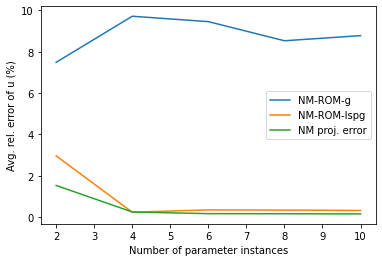

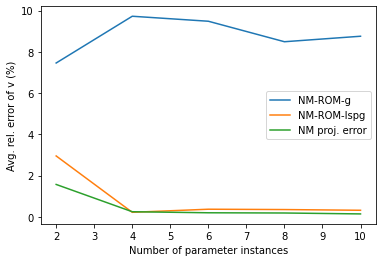

In [9]:
plt.figure()
plt.plot(nparamArr_NMROM,relErr_NMROM_g[0],nparamArr_NMROM,relErr_NMROM_lspg[0],nparamArr_NMROM,proErr_NMROM[0])
plt.legend(['NM-ROM-g','NM-ROM-lspg','NM proj. error'])
plt.xlabel('Number of parameter instances')
plt.ylabel('Avg. rel. error of u (%)')
plt.show()

plt.figure()
plt.plot(nparamArr_NMROM,relErr_NMROM_g[1],nparamArr_NMROM,relErr_NMROM_lspg[1],nparamArr_NMROM,proErr_NMROM[1])
plt.legend(['NM-ROM-g','NM-ROM-lspg','NM proj. error'])
plt.xlabel('Number of parameter instances')
plt.ylabel('Avg. rel. error of v (%)')
plt.show()

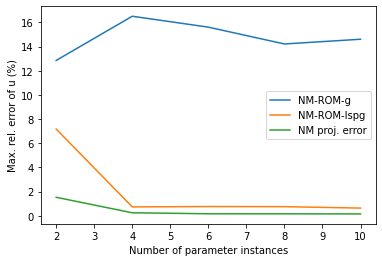

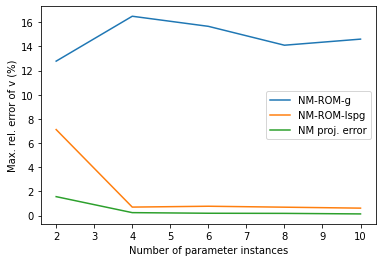

In [10]:
plt.figure()
plt.plot(nparamArr_NMROM,maxErr_NMROM_g[0],nparamArr_NMROM,maxErr_NMROM_lspg[0],nparamArr_NMROM,proErr_NMROM[0])
plt.legend(['NM-ROM-g','NM-ROM-lspg','NM proj. error'])
plt.xlabel('Number of parameter instances')
plt.ylabel('Max. rel. error of u (%)')
plt.show()

plt.figure()
plt.plot(nparamArr_NMROM,maxErr_NMROM_g[1],nparamArr_NMROM,maxErr_NMROM_lspg[1],nparamArr_NMROM,proErr_NMROM[1])
plt.legend(['NM-ROM-g','NM-ROM-lspg','NM proj. error'])
plt.xlabel('Number of parameter instances')
plt.ylabel('Max. rel. error of v (%)')
plt.show()

# Save data to mat file

In [11]:
dict_err={"relErr_NMROM_g":relErr_NMROM_g,"relErr_NMROM_lspg":relErr_NMROM_lspg,\
          "maxErr_NMROM_g":maxErr_NMROM_g,"maxErr_NMROM_lspg":maxErr_NMROM_lspg,\
          'proErr_NMROM':proErr_NMROM,'nparamArr_NMROM':nparamArr_NMROM}
savemat("./data/NMROM_Err.mat",dict_err)

pickle.dump(dict_err,open('./data/NMROM_Err.p','wb'))